# Разработка сентимент-анализа под задачу заказчика

## Анализ задачи

По условию задачи дана только небольшая тестовая выборка, подготовленной обучающей выборки нет. Поэтому выполнение задания можно разделить на следующие этапы:
* Подготовка обучающей выборки
    * Нахождение данных для обучения
    * Разметка данных на классы
* Обучение модели сентимент-анализа
    * Подбор алгоритма обучения
    * Экспериментирование с разными обучающими выборками и параметрами обучения
* Запуск обученной модели на тестовых данных

   ## Подготовка обучающей выборки
   ### Нахождение данных для обучения

Визуальный анализ тестовых данных показывает, что речь идет об отзывах на мобильные телефоны. Таким образом, нужно где-то найти базу отзывов на телефоны на русском языке. В первую очередь на ум приходит сервис Яндекс-Маркет, содержащий сведения и отзывы на множество моделей телефонов. Кроме того, отзывы на нем разделены на "Достоинства", "Недостатки" и "Комментарий", а также имеют общую оценку-рейтинг, которую можно было бы использовать для разметки на классы.

Для парсинга страниц с отзывами была использована библиотека Scrapy, упомянутая в предыдущих заданиях. Эта библиотека позволила обойти ограничения, связанные с блокировкой автоматических запросов со стороны сайта.

Использование Scrapy предполагает создание отдельного проекта со своей структурой, поэтому целиком привести его здесь и запустить из Ipython не получится. Код проекта приложен к архиву.

Было использовано 2 подхода к парсингу отзывов:
- парсинг полей "Достоинства" и "Недостатки"
- парсинг поля "Комментарий" и "Оценка"

Класс с основной логикой парсинга для библиотеки Scrapy (спайдер) приведен ниже:                                

In [1]:
import scrapy

# to run:
# scrapy crawl reviews -o reviews.json
class ReviewsSpider(scrapy.Spider):
    name = "reviews"

    start_urls = ['https://market.yandex.ru/catalog/54726/list?how=opinions&deliveryincluded=0&onstock=1']    

    def __init__(self):
        self.count = 0
        self.LIMIT = 5

    def parse(self, response):
        # follow links to phone pages
        for href in response.css('a.snippet-card__header-link::attr(href)').extract():
            link = href[:href.index('?')] + '/reviews'
            yield scrapy.Request(response.urljoin(link),
                                 callback=self.parse_phone)

        # follow link to the next review page
        next_page = response.css('a.n-pager__button-next::attr(href)').extract_first()
        if self.count < self.LIMIT and next_page is not None:
            next_page = response.urljoin(next_page)
            self.count += 1
            yield scrapy.Request(next_page, callback=self.parse)

    def parse_phone(self, response):
        for review in response.css('div.product-review-item'):                        
            pos = ' '.join(review.css('.product-review-item__stat:nth-child(4) .product-review-item__text::text').extract())                                       
            neg = ' '.join(review.css('.product-review-item__stat:nth-child(5) .product-review-item__text::text').extract())
            if len(pos) > len(neg):
                text = pos
                rating = 5
            else:
                text = neg
                rating = 1
            yield {
                'text': text,       
                'rating': rating,              
            }

        # follow link to the next review page
        next_page = response.css('a.n-pager__button-next::attr(href)').extract_first()
        if next_page is not None:
            next_page = response.urljoin(next_page)
            yield scrapy.Request(next_page, callback=self.parse_phone)

В качестве стартового URL используется адрес страницы со списком наиболее популярных телефонов по числу отзывов. Затем парсер переходит по ссылкам на страницы отзывов каждого телефона в списке и далее переходя по ссылкам "листает" страницы. Для отзывов из блока "Достоинства" присваивался рейтинг 5, из "Недостатков" - 1.

В другом варианте спайдера использовались блоки с полями "Комментарий" и "Оценка". Код спайдера приведен ниже:

In [2]:
import scrapy

# to run:
# scrapy crawl comments -o comments.json
class CommentsSpider(scrapy.Spider):
    name = "comments"

    start_urls = ['https://market.yandex.ru/catalog/54726/list?how=opinions&deliveryincluded=0&onstock=1']    

    def __init__(self):
        self.count = 0
        self.LIMIT = 15

    def parse(self, response):
        # follow links to phone pages
        for href in response.css('a.snippet-card__header-link::attr(href)').extract():
            link = href[:href.index('?')] + '/reviews'
            yield scrapy.Request(response.urljoin(link),
                                 callback=self.parse_phone)

        # follow link to the next review page
        next_page = response.css('a.n-pager__button-next::attr(href)').extract_first()
        if self.count < self.LIMIT and next_page is not None:
            next_page = response.urljoin(next_page)
            self.count += 1
            yield scrapy.Request(next_page, callback=self.parse)

    def parse_phone(self, response):
        for review in response.css('div.product-review-item'):            

            yield {
                'text': ' '.join(review.css('.product-review-item__stat:nth-child(6) .product-review-item__text::text').extract()),       
                'rating': review.css('div.rating::text').extract_first(),              
            }

        # follow link to the next review page
        next_page = response.css('a.n-pager__button-next::attr(href)').extract_first()
        if next_page is not None:
            next_page = response.urljoin(next_page)
            yield scrapy.Request(next_page, callback=self.parse_phone)

В этом варианте рейтинг мог быть любым от 1 до 5.
Результатом работы спайдеров scrapy были JSON-файлы вида:

    {"text": "Постоянно глючит. Нормально смогла попользоваться, используя различные приложения, 1 год. Дальше глюкнул\r Постоянно зависал. Из программ вылетал. Пользовалась всё остальное время не как смартфоном, а как телефоном.", "rating": 1},
    {"text": "1. HTC\r 2. Отличное качество изготовления\r 3. Отличное \"железо\", не тормозит\r 4. OS Android 4\r 5. Стекло не боится царапин\r 6. Play Market\r 7. Много аксессуаров", "rating": 5},
    {"text": "не советую покупать данное устройство.", "rating": "3"} ...
    
Количество записей в выборке в ходе экспериментов варьировалось от 6000 до 12000 записей.

### Разметка данных на классы
Разметка на классы выполнялась на основе поля "rating" из JSON-файла с отзывами. Если рейтинг меньше 4, то принимался класс 0 (отрицательный отзыв), иначе - 1 (положительный отзыв).

Далее приведен код загрузки данных, предобработки, обучения модели, нахождения оптимальных параметров и предсказания для тестовых данных.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import pandas as pd
import datetime
import numpy as np
from time import time
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from lxml import etree
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Добавление обрамляющих тегов в файл с тестовой выборкой, чтобы он был валидным XML-документом (для удобства парсинга)

In [5]:
def add_outer_tags(filename):
    with open(filename, 'r+') as f:        
        content = f.read()        
        f.seek(0, 0)
        firstline = f.readline()
        if '<data>' not in firstline:            
            f.seek(0, 0)
            f.write('<data>' + '\n' + content + '\n</data>')        

Определение класса для объектов обучающей выборки

In [6]:
def make_target(row):
   if row['rating'] < 4:
      return 0
   else:
      return 1

Предобработка обучающей выборки, добавление целевой метки

In [7]:
def prepare_data_set(data):
    data['target'] = data.apply(lambda row: make_target(row),axis=1)
    data = data.dropna(subset=['target'])
    data['target'] = data['target'].astype(int)   
    return data

Итератор по XML-файлу с тестовыми данными

In [8]:
def iter_tree(etree):
    n = -1
    for review in etree.iter('review'):
        n += 1
        yield (n, review.text)

Функция загрузки данных по обучающей и тестовой выборкам в датафреймы

In [9]:
def get_dataframes(training_data_file, test_data_file):
    df_training = pd.read_json(training_data_file)
    df_training = prepare_data_set(df_training)
    
    add_outer_tags(test_data_file)
    tree = etree.parse(test_data_file)
    df_test = pd.DataFrame(list(iter_tree(tree)), columns=['id', 'text'])
    
    return df_training, df_test

Преобразование данных из датафреймов в массивы

In [10]:
def read_data(df_training, df_test):
    X_train = df_training['text'].values
    X_test = df_test['text'].values
    id_test = df_test['id'].values
    y_train = df_training['target'].values                  
    return X_train, y_train, id_test, X_test

## Обучение модели для сентимент-анализа

### Подбор алгоритма обучения

Различные сочетания алгоритмов для обучения (выделение признаков, классификация) и перечень их параметров для перебора при  поиске наилучшего варианта

In [11]:
def get_pipeline_and_params_1():    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier()),
    ])
    parameters = {
        'vect__max_df': (0.75, 1),
        #'vect__max_features': (None, 5000, 10000, 50000),
        'vect__ngram_range': ((1, 1), (1, 3), (1, 2)),  # unigrams or bigrams
        #'tfidf__use_idf': (True, False),
        #'tfidf__norm': ('l1', 'l2'),
        #'clf__alpha': (0.00001, 0.000001),
        #'clf__penalty': ('l2', 'elasticnet'),
        #'clf__n_iter': (10, 50, 80),
    }
    return pipeline, parameters

In [12]:
def get_pipeline_and_params_2():
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('logreg', LogisticRegression()),
    ])
    parameters = {
        'tfidf__max_df': (0.6,0.8,1),
        #'tfidf__min_df': (0, 5, 10, 15),
        'tfidf__ngram_range': ((1, 1), (1, 2), (1,3), (2,3)),  # unigrams or bigrams
        #'tfidf__use_idf': (True, False),
        #'tfidf__norm': ('l1', 'l2'),   
        #'logreg__C': (0.0001, 0.01, 1),
        #'logreg__penalty': ('l2', 'l1'),  
    }
    return pipeline, parameters

In [13]:
def get_pipeline_and_params_3():
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('logreg', LogisticRegression()),
    ])
    parameters = {
        'vect__max_df': (0.6, 1.0),
        'vect__min_df': (0, 5),
        #'vect__stop_words': ('english', None),
        'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams        
        #'logreg__C': (0.0001, 0.01, 1),
        #'logreg__penalty': ('l2', 'l1'),        
    }
    return pipeline, parameters

Предсказание результата для тестовых данных

In [14]:
def predict(predictor, data_train, y, id_test, data_test, cv_score=None):
    predictor.fit(data_train, y)
    joblib.dump(predictor, './SentimentAnalysisModel.pkl')    
    prediction = predictor.predict(data_test)
    #print predictor
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    filepath_prediction = 'data/prediction-%s-data.csv' % timestamp
    filepath_description = 'data/prediction-%s-estimator.txt' % timestamp      

    prediction_str = ['pos' if p == 1 else 'neg' for p in prediction]
    # Create a dataframe with predictions and write it to CSV file   
    predictions_df = pd.DataFrame(data=prediction_str, columns=['y'])
    predictions_df.to_csv(filepath_prediction, sep=',', index_label='Id')

    # Write a short description of the classifier that was used
    f = open(filepath_description, 'w')
    f.write(str(predictor))
    score = '\nCross-validation score %.8f' % cv_score    
    f.write(score)
    f.close()

### Экспериментирование с разными обучающими выборками и параметрами обучения

Поиск оптимальных параметров модели

In [15]:
def do_grid_search(pipeline, parameters, X_train, y_train):
    grid_search = GridSearchCV(pipeline, parameters, scoring='accuracy')
    t0 = time()
    grid_search.fit(X_train, y_train)
    print "done in %0.3fs" % (time() - t0)
    
    print("Best score: %.4f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search

Общая структура эксперимента: выбор конфигурации, поиск параметров, предсказание на основе наилучшего варианта

In [16]:
def do_experiment(X_train, y_train, id_test, X_test, get_pipeline_and_params):      
    pipeline, parameters = get_pipeline_and_params()
    gs = do_grid_search(pipeline, parameters, X_train, y_train)
    predict(gs.best_estimator_, X_train, y_train, id_test, X_test, gs.best_score_)

Получение датафреймов с обучающей и тестовой выборками. Используется подготовленный с помощью Scrapy JSON-файл, содержащий 11665 отзывов о мобильных телефонах с Яндекс.Маркета.

In [17]:
df_training, df_test = get_dataframes('reviews11665.json', 'test.csv')

Общий вид датафреймов

In [18]:
df_training.head()

,rating,text,target
0,1,"В сегменте бюджетников, за такую цену, недоста...",0
1,1,"Недостатков кроме маленькой памяти нет, разве ...",0
2,1,Нет гарнитуры в комплекте. Пожадничали корейцы...,0
3,1,Постоянно глючит. Нормально смогла попользоват...,0
4,1,Сказать что батарея слабая-не сказать ничего. ...,0


In [19]:
df_test.head()

,id,text
0,0,"Ужасно слабый аккумулятор, это основной минус ..."
1,1,ценанадежность-неубиваемостьдолго держит батар...
2,2,"подробнее в комментариях\nК сожалению, факт по..."
3,3,я любительница громкой музыки. Тише телефона у...
4,4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."


Гистограмма распределения классов в обучающей выборке

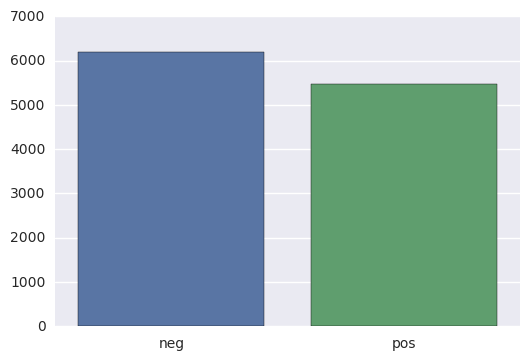

In [52]:
ax = sns.barplot(df_training['target'].value_counts().keys(), df_training['target'].value_counts().values)
ax.set_xticklabels(['neg', 'pos'])

Подготовка данных

In [53]:
X_train, y_train, id_test, X_test = read_data(df_training, df_test) 

Проведение серии экспериментов

In [54]:
do_experiment(X_train, y_train, id_test, X_test, get_pipeline_and_params_1)

done in 41.642s
Best score: 0.9457
Best parameters set:
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


In [55]:
do_experiment(X_train, y_train, id_test, X_test, get_pipeline_and_params_2)

done in 91.901s
Best score: 0.9314
Best parameters set:
	tfidf__max_df: 0.6
	tfidf__ngram_range: (1, 2)


In [56]:
do_experiment(X_train, y_train, id_test, X_test, get_pipeline_and_params_3)

done in 38.843s
Best score: 0.9324
Best parameters set:
	vect__max_df: 0.6
	vect__min_df: 0
	vect__ngram_range: (1, 2)


## Запуск обученной модели на тестовых данных

Эксперименты показали, что наиболее хороший результат дает обучающая выборка составленная первым способом (на основе блоков "Достоинства" и "Недостатки" из каждого отзыва). Лучшее качество на кросс-валидации было достигнуто при использовании признаков, сформированных Tf-Idf преобразованием, и классификатора SGDClassifier.
Предсказание результата для отзывов из тестовой выборки с помощью этой модели показало точность 0.96 в конкурсе на сайте Kaggle.